## Summary
In this notebook, the paired data from MSV000084950 is analysed for the NPClassScore paper.

The newly developed implementation of NPClassScore is used in combination with Metcalf scoring to discover BGC-MS/MS spectrum links in the MSV000084950 dataset. Validated links from the PoDP are used to validate the results.

Sections:
- Loading the MSV000084950 dataset
- Scoring using the new NPClassScore method
- Investigating NPClassScore cutoff
- Counting number of links
- Making plots showing the filtered links
- Investigate known links

## Loading MSV000084950 dataset

In [1]:
import sys, csv, os
# if running from clone of the git repo
sys.path.append('../../prototype')

# import the main NPLinker class. normally this all that's required to work
# with NPLinker in a notebook environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nplinker.nplinker import NPLinker
from nplinker.nplinker import Spectrum
from collections import Counter, defaultdict

In [18]:
# load local crusemann data
npl = NPLinker(
    {'dataset':
     {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084950/'},
    'docker':
     {'run_canopus': True}})
npl.load_data()

12:06:31 [INFO] config.py:121, Loading from local data in directory /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084950/
12:06:31 [WARNING] loader.py:50, WARNING: unable to find extra_nodes_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084950/quantification_table_reformatted/*.csv"
12:06:31 [WARNING] loader.py:50, WARNING: unable to find metadata_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084950/metadata_table/metadata_table*.txt"
12:06:31 [WARNING] loader.py:50, WARNING: unable to find quantification_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084950/quantification_table/quantification_table*.csv"
12:06:31 [INFO] loader.py:84, Trying to discover correct bigscape directory under /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data

True

In [19]:
# Basic functionality
# ===================
#
# Once you have an NPLinker object with all data loaded, there are a collection of simple
# methods and properties you can use to access objects and metadata. Some examples are 
# given below, see https://nplinker.readthedocs.io/en/latest/ for a complete API description.

# configuration/dataset metadata
# - a copy of the configuration as parsed from the .toml file (dict)
print(npl.config) 
# - the path to the directory where various nplinker data files are located (e.g. the 
#   default configuration file template) (str)
print(npl.data_dir)
# - a dataset ID, derived from the path for local datasets or the paired platform ID
#   for datasets loaded from that source (str)
print(npl.dataset_id)
# - the root directory for the current dataset (str)
print(npl.root_dir)

# objects
# - you can directly access lists of each of the 4 object types:
print('BGCs:', len(npl.bgcs))
print('GCFs:', len(npl.gcfs)) # contains GCF objects
print('Spectra:', len(npl.spectra)) # contains Spectrum objects
print('Molecular Families:', len(npl.molfams)) # contains MolecularFamily objects

{'loglevel': 'INFO', 'logfile': '', 'log_to_stdout': True, 'repro_file': '', 'dataset': {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084950/', 'overrides': {}, 'platform_id': ''}, 'antismash': {'antismash_format': 'default', 'ignore_spaces': False}, 'docker': {'run_bigscape': True, 'extra_bigscape_parameters': '', 'run_canopus': True}, 'webapp': {'tables_metcalf_threshold': 2.0}, 'scoring': {'rosetta': {}}}
../../prototype/nplinker/data

/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084950/
BGCs: 301
GCFs: 184
Spectra: 729
Molecular Families: 341


## Scoring using the new NPClassScore method
Use the scoring methods in NPLinker to find links with:
- Metcalf scoring
- Metcalf + NPClassScore scoring

In [21]:
mc = npl.scoring_method('metcalf')

# Now mc is an instance of the class that implements Metcalf scoring. Once
# you have such an instance, you may change any of the parameters it exposes.
# In the case of Metcalf scoring, the following parameters are currently exposed:
# - cutoff (float): the scoring threshold. Links with scores less than this are excluded
# - standardised (bool): set to True to use standardised scores (default), False for regular
mc.cutoff = 2.5
mc.standardised = True

results = npl.get_links(npl.gcfs, mc, and_mode=True)

# get_links returns an instance of a class called LinkCollection. This provides a wrapper
# around the results of the scoring operation and has various useful properties/methods:
#
# - len(results) or .source_count will tell you how many of the input_objects were found to have links
print('Number of results: {}'.format(len(results)))
# - .sources is a list of those objects
objects_with_links = results.sources
# - .links is a dict with structure {input_object: {linked_object: ObjectLink}} 
objects_and_link_info = results.links
# - .get_all_targets() will return a flat list of *all* the linked objects (for all sources)
all_targets = results.get_all_targets() 
# - .methods is a list of the scoring methods passed to get_links
methods = results.methods

Number of results: 184


In [22]:
# Initialise NPClassScore scoring the same way
# default method: 'mix' meaning use both CANOPUS and MolNetEnhancer with priority to CANOPUS
npcl = npl.scoring_method('npclassscore')
npcl.cutoff = 0.25

# Now only links are kept that pass the cutoff for both methods
results_both = npl.get_links(npl.gcfs, [mc, npcl], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_both)))
print(results_both.methods)

12:07:23 [INFO] methods.py:968, Set up NPClassScore scoring
12:07:23 [INFO] methods.py:970, Please choose one of the methods from ['mix', 'main', 'canopus', 'molnetenhancer']
12:07:23 [INFO] methods.py:976, Currently the method 'mix' is selected
12:07:24 [INFO] methods.py:982, Running NPClassScore...
12:07:24 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
12:07:24 [INFO] methods.py:1003, Calculating NPClassScore for 184 objects to 729 targets (36852 pairwise interactions that share at least 1 strain). This might take a while.
12:07:27 [INFO] methods.py:1052, NPClassScore completed in 3.4s
Number of results for Metcalf and NPClassScore scoring: 168
{<nplinker.scoring.methods.NPClassScoring object at 0x7f61e2fe9f98>, <nplinker.scoring.methods.MetcalfScoring object at 0x7f61e471f9b0>}


In [23]:
# Also create an object with both Metcalf and NPClassScore with a cutoff of 0 to investigate proper cutoff
npcl_0 = npl.scoring_method('npclassscore')
npcl_0.cutoff = 0

# Now only links are kept that pass the cutoff for both methods
results_0 = npl.get_links(npl.gcfs, [mc, npcl_0], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_0)))
print(results_0.methods)

12:07:28 [INFO] methods.py:982, Running NPClassScore...
12:07:28 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
12:07:28 [INFO] methods.py:1003, Calculating NPClassScore for 184 objects to 729 targets (36852 pairwise interactions that share at least 1 strain). This might take a while.
12:07:31 [INFO] methods.py:1052, NPClassScore completed in 3.4s
Number of results for Metcalf and NPClassScore scoring: 180
{<nplinker.scoring.methods.NPClassScoring object at 0x7f61e5ae3f98>, <nplinker.scoring.methods.MetcalfScoring object at 0x7f61e471f9b0>}


In [38]:
mne_no_matches = 0
for spec in npl.spectra:
    spec_can = npl.chem_classes.canopus.spectra_classes.get(str(spec.spectrum_id))
    if not spec_can:
        spec_mne = npl.chem_classes.molnetenhancer.spectra_classes(str(spec.spectrum_id))
        if spec_mne:
#             print(spec_mne)
            if spec_mne[0][0] == 'no matches':
                mne_no_matches += 1
mne_no_matches

173

## Investigating NPClassScore cutoff
We choose 0.25 as a cutoff as around this value there is a marked drop in the number of links per GCF.

In [24]:
# gradient of class linking score cutoff

cs_cutoffs = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
d_all_num_links = []
d_all_num_filtered_links = {cut: [] for cut in cs_cutoffs}
d_all_no_scores = []

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    
    # loop through cutoffs
    for cs_cut in cs_cutoffs:
        num_filtered_links = 0
        if gcf in results_0.links:
            # calculate number of links with npcl filtering
            num_filtered_links = len([link_data for link_data in results_0.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum) and 
                                      float(npcl_0.format_data(link_data[npcl_0])) > cs_cut])
        d_all_num_filtered_links[cs_cut].append(num_filtered_links)
    d_all_num_links.append(num_links)

In [25]:
print(f"NPClassScore_cutoff\tNumber_of_links\tChange")
print(f"0\t{np.mean(d_all_num_links):.2f}")
for cs_cut, filt_links in d_all_num_filtered_links.items():
    print(f"{cs_cut}\t{np.mean(filt_links):.2f}\t{(np.mean(filt_links)-np.mean(d_all_num_links))/np.mean(d_all_num_links):.2f}")

NPClassScore_cutoff	Number_of_links	Change
0	26.98
0.125	13.17	-0.51
0.25	11.59	-0.57
0.375	10.11	-0.63
0.5	8.86	-0.67
0.625	8.77	-0.67
0.75	4.42	-0.84
0.875	1.34	-0.95


## Counting number of links
For each GCF count the number of links with and without NPClassScore filtering using the chosen cutoff of 0.25.

In [26]:
# loop through all gcfs (objects) and count how many links exist (spectra)
all_num_links = []
all_num_filtered_links = []
all_no_scores = []

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    num_filtered_links = 0
    if gcf in results_both.links:
        num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                  if isinstance(link_data.target, Spectrum)])
    all_num_links.append(num_links)
    all_num_filtered_links.append(num_filtered_links)

np.mean(all_num_links), np.mean(all_num_filtered_links)

(26.97826086956522, 11.592391304347826)

In [27]:
# change in average links per GCF
(np.mean(all_num_filtered_links)-np.mean(all_num_links))/np.mean(all_num_links)

-0.5703062046736503

## Making plots showing the filtered links

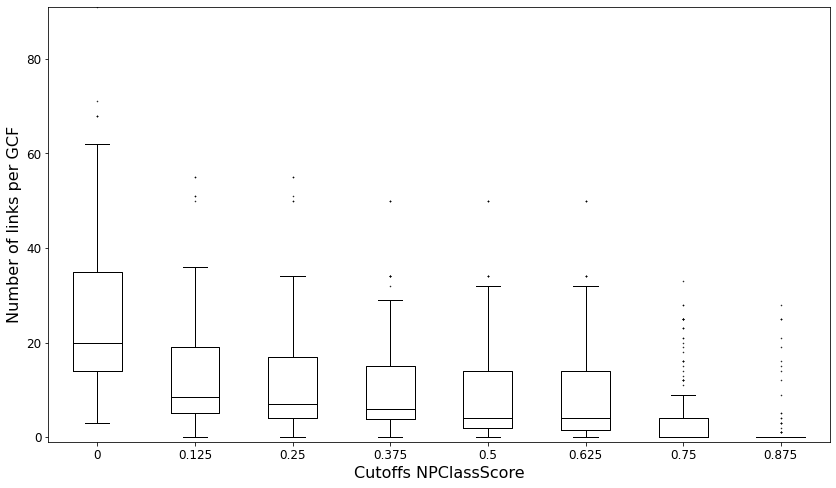

In [33]:
sorted_filt_items = sorted(d_all_num_filtered_links.items())
labels = ["0"] + [f"{cut}" for cut, vals in sorted_filt_items]
xs = [d_all_num_links] + [vals for keys, vals in sorted_filt_items]
lg_size = 14
custom_xlim = (-1, max(d_all_num_links))
links_title = "Number of links per GCF"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.boxplot(xs, labels=labels, flierprops={"markersize": 0.5}, medianprops={"color": "black"})
plt.setp(ax, ylim=custom_xlim, xlabel="Cutoffs NPClassScore", ylabel=links_title)
figout = "/home/louwe015/NPLinker/boxplot_cutoffs_MSV000084950_npclass_mix_can-mne_figure.svg"
plt.savefig(figout)

Use MNE when there is no CANOPUS prediction
Bin size: 5


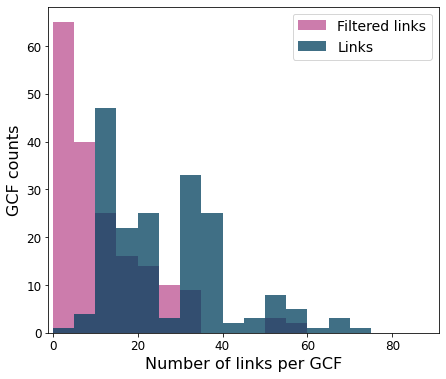

In [37]:
print("Use MNE when there is no CANOPUS prediction")
labels = ["Links", "Filtered links"]
colours = ["#003f5c", "#bc5090", "#ffa600"]
xs = [all_num_links, all_num_filtered_links]
lg_size = 14
custom_xlim = (-1, max(d_all_num_links))
bin_size = 5
print("Bin size:", bin_size)
n_bins = np.arange(0, max(d_all_num_links), bin_size)
links_title = "Number of links per GCF"
count_title = "GCF counts"
hist_type = "stepfilled"
alpha = 0.75

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
ax0.hist(xs[:2], bins=n_bins, density=False, histtype=hist_type, stacked=False, label=labels[:2],
         color=colours[:2], alpha=alpha)
ax0.legend(prop={'size': lg_size})
plt.setp(ax0, xlim=custom_xlim, xlabel=links_title, ylabel=count_title)
figout = "/home/louwe015/NPLinker/filtered_links_MSV000084950_mix_can-mne_figure_new.svg"
plt.savefig(figout)

## Investigate known links

In [30]:
known_links_dict = {}

### Staurosporine

In [31]:
# Find the right GCF by seeing if this mibig occurs in the knownclusterblast results
key = 'bgc0000827'
result_bgcs = defaultdict(list)
interest_lines = []
for bgc in npl.bgcs:
    as_file = bgc.antismash_file
    with open(as_file) as inf:
        for x in range(1000):
            line = inf.readline().lower()
            if key in line:
                result_bgcs[bgc].append(line.strip())
print(len(result_bgcs))
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

0
set() 0


In [32]:
name_hit = 'staurosporine'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [89513]  # based on library hits

result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 534][0]
result_gcf, list(result_gcf.bgcs)[:5]

IndexError: list index out of range

In [ ]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 10
include_below_cutoff = False
prev_mc = 10**100
delay = 0
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if count == show_x:
        break
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        i += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score[0][0] > cutoff:
                if cur_mc < prev_mc:
                    count += 1
                    count += delay
                    delay = 0
                else:
                    delay += 1
                pref = f"{count}."
                prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

In [ ]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score[0][0] > cutoff:
                filtered_counts += 1
known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)